# Data analysis technical details

This notebook encapsulates all the research we’ve conducted for the CASSINI Hackathon 2023. The techniques described below are the backbone of our idea’s implementation.

## Population estimation

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
image_path = './people_cluster_detection/false_color_city_image.png'

Thanks to commonly used image processing techniques, we can isolate human infrastructure from a satellite image and estimate the place's population.

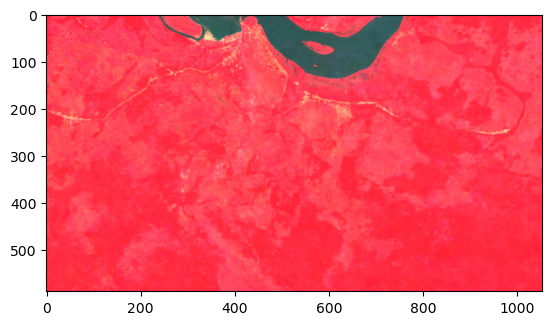

In [3]:
original_image = cv2.imread(image_path)
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
plt.imshow(original_image_rgb)
plt.show()

### Pixel filtering

After this operation pixels left on the image mostly represent human-made chnages to the area.

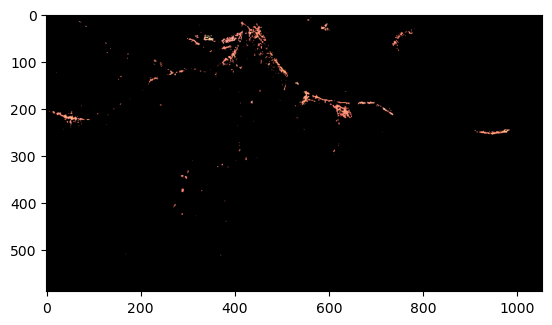

In [4]:
def extractInfrastructurePixels(original_image):
    hMin = 2
    sMin = 0
    vMin = 255

    hMax = 18
    sMax = 154
    vMax = 255

    lower = np.array([hMin, sMin, vMin])
    upper = np.array([hMax, sMax, vMax])

    hsv = cv2.cvtColor(original_image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower, upper)
    output = cv2.bitwise_and(original_image,original_image, mask= mask)
    output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    return output, output_rgb

outputs = extractInfrastructurePixels(original_image)

output_rgb = outputs[1]
plt.imshow(output_rgb)
plt.show()

### Counting the remaining pixels

We can estimate population size by counting the pixels that remain on the image after filtering. This method works best if there's not a lot of multi-store buildings, but since we're focusing on poorly developed areas, the results should be quite accurate.

In [5]:
output_greyscale = cv2.cvtColor(output_rgb, cv2.COLOR_BGR2GRAY)
print(f"population: approx. {cv2.countNonZero(output_greyscale)} people")

population: approx. 4824 people


### Other population sources

The estimation method described above can be could be verified and enhanced by data available on [Google Earth](https://developers.google.com/earth-engine/datasets/catalog/projects_sat-io_open-datasets_ORNL_LANDSCAN_GLOBAL).

## African power grid exploration

<https://africagrid.energydata.info/> shares data on the African electrical grid, its nodes, and the power that they’re carrying. It’s also worth noting that power lines that are planned are also included in the dataset.

### Power grid data in analyzable format

[The World Bank](https://datacatalog.worldbank.org/search/dataset/0040465/Africa---Electricity-Transmission-and-Distribution-Grid-Map) makes this data available through downloadable files that can be manipulated and queried to find the node that is the closest to a local community.

## Fire detection and fire-prone places

Knowledge about fire occurrences is crucial for NGOs it helps in faster responding to events. Aim of this notebook is to develop a base for future development of solutions for prognosis of such events.

Detecting fire-prone places will work on historical data. It will check how often wildfires occurs on selected area.
https://github.com/satellite-image-deep-learning/techniques
Sources:
- https://firms.modaps.eosdis.nasa.gov/
- Sentinel 2

### Jupyter kernel restart

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


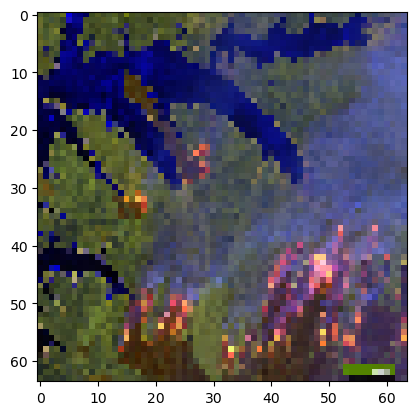

In [6]:
from keras.models import load_model

classifier = load_model('classifier.h5')

import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt

test_image = image.load_img('.\\fire-detection\\sentinel2-fire.jpg', target_size = (64, 64))
test_image_np = image.img_to_array(test_image)


plt.imshow(test_image)
plt.show()

In [ ]:
test_image = np.expand_dims(test_image_np, axis = 0)
result = classifier.predict(test_image)

if result[0][0] == 1:
  prediction = 'notfire'
else:
  prediction = 'fire'
print(prediction)

## Locating nearest water well

One of the most important humanitarian aid areas e.g in Africa is providing access to clean drinking water. Some organisations that maintain water wells share their locations. Gaps in this data can be filled by object detection algorithms trained to detect water wells from satellite images.

Attached below is a map with marked wells maintained by [Water For Good](https://waterforgood.org/well-map/):

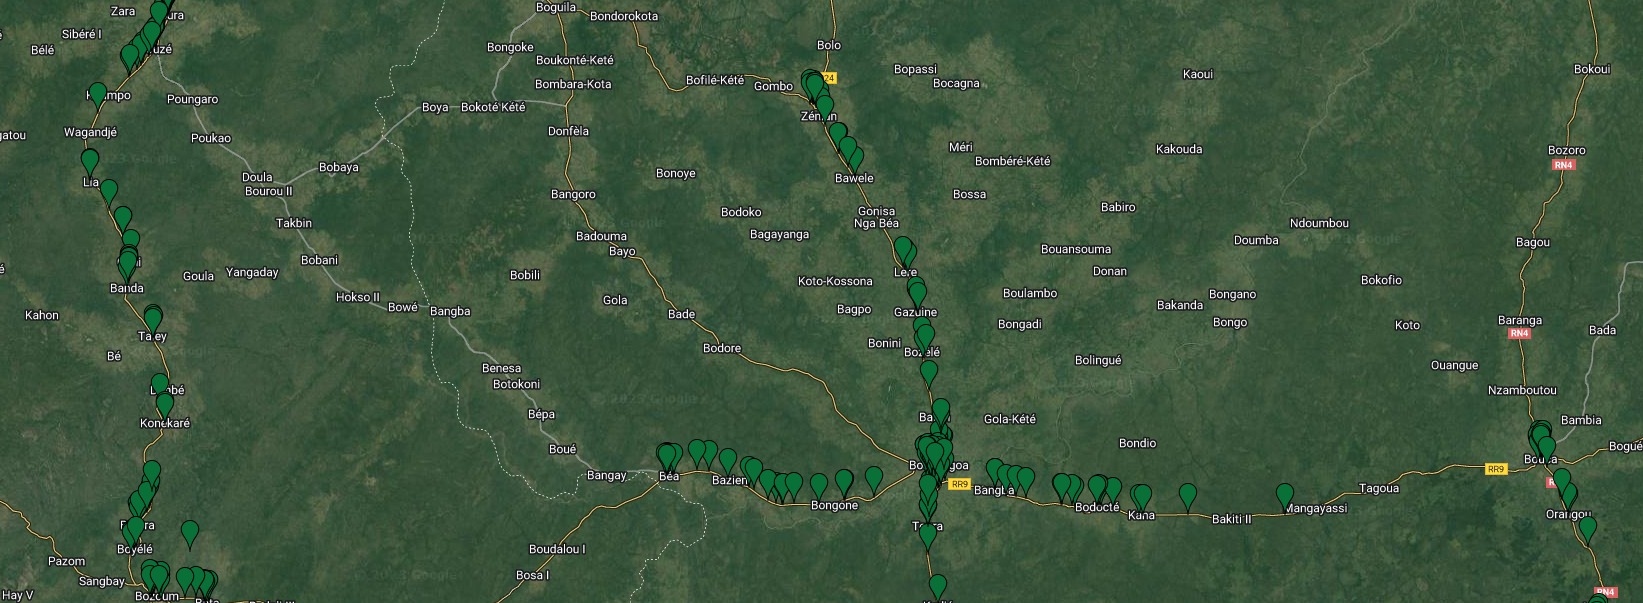

In [6]:
from IPython.display import Image

Image('wells.png')

In [ ]:
from lxml import html

doc = html.fromstring(kml)

### Processing geospatial data on working water wells

Data is available in KMZ format; it contains points with geographic coordinates that represent wells. We parse the file and collect coordinates is a list format.

In [ ]:
def parseKMZFile(kmz_file_path: str) -> list:
    """
    Parses Google My Maps KMZ file into a list of pointmarks.
    
    Parameters
    ---
    - `kmz_file_path` - path to KMZ file to be analyzed.

    Returns
    ---
    A list of placemark coordinates in `[latitude, longitude]` format
    """

    unpacked_kmz = ZipFile('Functional Pumps.kmz', 'r')
    map_point_data = unpacked_kmz.open('doc.kml', 'r').read()
    map_point_data_parsed = html.fromstring(map_point_data)

    wells_coordinates = []

    for placemark_coordinate in map_point_data_parsed.cssselect("Document Placemark Point"):
        well_coordinates_raw = placemark_coordinate.text_content()
        well_coordinates_split = well_coordinates_raw.split(',')
        well_coordinates = (
        float(well_coordinates_split[1].strip()),
        float(well_coordinates_split[0].strip())
    )
        wells_coordinates.append(well_coordinates)
    return wells_coordinates

### Finding distance to the closest water well

Since we have coordinates in a list, we just need to find the least distance to any of them:

In [ ]:
from geopy.distance import distance

def closestWellFromLocation(origin_coordinates: float, wells_coordinates: list) -> tuple:
    """
    Returns the position of the well that is closest to origin point and distance between them.

    All coordinates should be in `[latitude, longitude]` format.
    """
    distances_to_wells = [
        distance(origin_coordinates, well_coordinates).m for well_coordinates in wells_coordinates
    ]
    minimal_distance = min(distances_to_wells)
    index_of_the_closest_well = distances_to_wells.index(minimal_distance)
    closest_well_coordinates = wells_coordinates[index_of_the_closest_well]
    return(
        closest_well_coordinates,
        minimal_distance
    )

In [ ]:
random_point_near_wells = [5.74639, 19.12389]

wells_coordinates = parseKMZFile('./nearest_well/Functional Pumps.kmz')

closest_well_coordinates, distance_to_well = closestWellFromLocation(random_point_near_wells, wells_coordinates)
closest_well_latitude, closest_well_longitude = closest_well_coordinates
distance_to_well = round(distance_to_well)

print(f"The closest water well is at lat {closest_well_latitude}, lon {closest_well_longitude}; the distance to it is approx. {distance_to_well}m")

# Plant disease detection
Sources:
- https://www.sciencedirect.com/science/article/abs/pii/S2352938521001361
- https://www.mdpi.com/2072-4292/14/23/5947
- https://link.springer.com/article/10.1007/s43154-020-00004-7/tables/1
